# Autocorrelación Espacial o Error de Especificación
### Autor: Marcos Herrera (mherregomez@gmail.com)

Este ejercicio muestra que detectar autocorrelación espacial con determinados tests no implica que deba estimarse un modelo espacial ya que puede ser un problema de especificación. 
El ejercicio requiere una batería de tests, Lagrange Multiplier Testing Suite, disponibles en la web de Donald Lacombe: http://myweb.ttu.edu/dolacomb/matlab.html.

McMillen (2003,https://journals.sagepub.com/doi/10.1177/0160017602250977) supone un modelo urbano donde la densidad del empleo depende de la distancia al principal centro de negocios, existiendo además un sub-centro de negocios local.
El modelo verdadero es $$ y_i = \beta_0 + \beta_1 DCBD_i +  \beta_2 SUB_i + \beta_3 DSUB_i, $$
con $ y_i $ como el logaritmo de la densidad del empleo y siendo $ DCBD_i $ la distancia al principal centro de negocios de la ciudad. El subcentro de negocios de tipo local es capturado por la variable $ SUB_i $ que es una dummy para el centro local y $ DSUB_i $ que mide el impacto de la distancia en ese centro local. 

El experimento Monte Carlo genera los datos con este modelo verdadero, pero estima tres modelos diferentes: (1) el verdadero (correctamente especificado) con 4 coeficientes; y dos modelos subespecificados: (2) un modelo con 3 variables y (3) un modelo con 2 variables.

Los residuos de estos tres modelos son utilizados para contrastar la presencia de autocorrelación espacial.
Los tests espaciales usan una matriz de contactos por contigüidad usando la distancia en línea recta: cada observación tiene como vecino a 2 observaciones. Los resultados muestran que usar el I de Moran o los LM simples detectan erróneamente efectos espaciales. Pero si se usan los tests LM robustos no se detectan efectos espaciales omitidos. El uso conjunto de los tests puede usarse para mejorar la especificación final.

### Parámetros del Monte Carlo

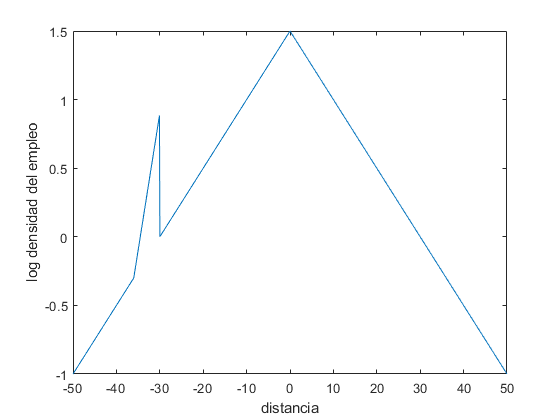

In [42]:
n = 1000; b0 = 1.5; b1 = -0.05; b2 = -0.15; b3 = 0.9;
x = [-50:0.1001:50]';
DCBD = abs(x);
log_employ_dens0 = 1.5 - 0.05*DCBD;
SUB = zeros(length(x),1);
for i = 1:length(x);
    if x(i)>-36
        if x(i)<-30
            SUB(i,1)= 1;
        end;
    end;
end
DSUB = SUB.*abs(-30-x);
log_employ_dens = 1.5-0.05*DCBD-0.15*DSUB+0.9*SUB;
plot(x, log_employ_dens); xlabel('distancia'); ylabel('log densidad del empleo')

In [13]:
XX = [ones(n,1) DCBD DSUB SUB]; 
betas = [b0 b1 b2 b3]';
sd_u = sqrt(var(XX*betas)/4);

In [14]:
Wbin = zeros(n);
for i = 1:n;
    for j = 1:n;
        if (abs(i-j)==1)
            Wbin(i,j)=1;
        end;
    end;
end;
W = normw(Wbin);

In [17]:
MC = [];
count = 0;
reps = 100;
sistem = XX*betas; 
tic
for xx=0:2;
    X = XX(:,1:(4-xx));
    for i=1:reps
        u = normrnd(0,sd_u,[1,n])';
        y = sistem + u;
        count = count+1;
        res1 = moran(y,X,W);
        res2 = lmlag(y,X,W);
        res3 = lmlag_robust(y,X,W);
        res4 = lmerror(y,X,W);
        res5 = lmerror_robust(y,X,W);
        res6 = ols(y,X);
        s = size(X,2);
        MC(count,1) = s;
        MC(count,2) = res1.prob;
        MC(count,3) = res2.prob;
        MC(count,4) = res3.prob;
        MC(count,5) = res4.prob;
        MC(count,6) = res5.prob;
        MC(count,7) = res6.rsqr;
    end;
end;
toc

Elapsed time is 181.725565 seconds.



In [43]:
% Pct rechazo modelo correcto
B=MC(any(MC==4,2),:);
BB=mean(B(:,2:6)<0.05).*100;

% Pct rechazo modelo Mal-especificado 1: 3 X's (const,DCBD,DSUB) 
C=MC(any(MC==3,2),:);
CC=mean(C(:,2:6)<0.05).*100;

% Pct rechazo Misspecified model 2: 2 X's (const,DCBD)
% Modelo usado en McMillen (2003)
D=MC(any(MC==2,2),:);
DD=mean(D(:,2:6)<0.05).*100;
fprintf('___________________________________________\n')
fprintf('          Tabla de McMillen (2003) \n')
fprintf('     Pctje rechazo: H0 no-autocor. esp.\n')
fprintf('-------------------------------------------\n')
fprintf('       Model  k   I Moran   LMerror \n');
fprintf('       True   4   %05.2f     %05.2f\n', [BB(1) BB(4)]);
fprintf('       Miss1  3   %05.2f     %05.2f\n', [CC(1) CC(4)]);
fprintf('       Miss2  2   %05.2f     %05.2f\n', [DD(1) DD(4)]);
fprintf('___________________________________________\n')
fprintf('\n')
fprintf('\n')
fprintf('_________________________________________________________\n')
fprintf('      Tabla de McMillen ampliada a tests robustos \n')
fprintf(' Porcentaje de rechazo: H0 no-autocorrelación espacial \n')
fprintf('---------------------------------------------------------\n')
fprintf('Model  k   I Moran   LMlag    RLMlag   LMerror   RLMerror \n');
fprintf('True   4   %05.2f     %05.2f    %05.2f    %05.2f     %05.2f\n', BB);
fprintf('Miss1  3   %05.2f     %05.2f    %05.2f    %05.2f     %05.2f\n', CC);
fprintf('Miss2  2   %05.2f     %05.2f    %05.2f    %05.2f     %05.2f\n', DD);
fprintf('_________________________________________________________\n')
fprintf('\n')


___________________________________________
          Tabla de McMillen (2003) 
     Pctje rechazo: H0 no-autocor. esp.
-------------------------------------------
       Model  k   I Moran   LMerror 
       True   4   03.00     04.00
       Miss1  3   69.00     64.00
       Miss2  2   87.00     87.00
___________________________________________


_________________________________________________________
      Tabla de McMillen ampliada a tests robustos 
 Porcentaje de rechazo: H0 no-autocorrelación espacial 
---------------------------------------------------------
Model  k   I Moran   LMlag    RLMlag   LMerror   RLMerror 
True   4   03.00     04.00    06.00    04.00     05.00
Miss1  3   69.00     65.00    13.00    64.00     13.00
Miss2  2   87.00     87.00    02.00    87.00     02.00
_________________________________________________________


